In [107]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\qwert\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [108]:
# Считываем ДС
df = pd.read_csv('labeled.csv', sep=',')

In [109]:
# размер ДС
df.shape

(14412, 2)

In [110]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [111]:
# Приведу значения в столбце toxic к int
df["toxic"] = df["toxic"].apply(int)

In [112]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [113]:
# Расперделение комментов 1/0
df["toxic"].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [114]:
# считываю токсичные комменты:
for toxic in df[df["toxic"] == 1]["comment"].head(10):
    print(toxic)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)

Для каких стан является эталоном современная система здравоохранения РФ? Для Зимбабве? Ты тупой? хохлы

УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РАЗВОРУЮТ КАК ВСЕГДА! УЖЕ ТРЕЩИНАМИ ПОШ Л! ТУПЫЕ КИТАЗЫ НЕ МОГУТ НИЧЕГО НОРМАЛЬНО СДЕЛАТЬ!

Ебать тебя разносит, шизик.

Обосрался, сиди обтекай

Зачем ты пишешь хуйню, дегенерат? Поцелуй в губы ! поцелую в засос.



In [115]:
# считываю нетоксичные комменты:
for toxic in df[df["toxic"] == 0]["comment"].head(10):
    print(toxic)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [116]:
#разделим ДС на учебный
from sklearn.model_selection import train_test_split

In [130]:
train_df, test_df = train_test_split(df, test_size = 500)

In [131]:
test_df.shape

(500, 2)

In [132]:
# Проверю распределение данных в тренируемых и тестовых ДС

In [133]:
test_df["toxic"].value_counts()

0    341
1    159
Name: toxic, dtype: int64

In [134]:
train_df["toxic"].value_counts()

0    9245
1    4667
Name: toxic, dtype: int64

In [135]:
# Распределение примерно 2:1 как и в оригинальном ДС

In [136]:
#Для работы с текстом будем использовать модель "Логистической регрессии"

In [137]:
# Сперва предобработаем текст
# 1) разобъем предложения на токены

In [138]:
# берем пример
sentence_example = df.iloc[1]['comment']
# применяем функ-ю word_tokenize из библ. nltk для анализа текста - разбиваем текст на части (токены)
tokens = word_tokenize(sentence_example, language = 'russian')
# Убираем все знаки пунктуации с помощью 'string' и методом punctuation
tokens_without_punctuations = [i for i in tokens if i not in string.punctuation]
# Достаем русские стоп-слова из библеотеки nltk
rus_stop_words = stopwords.words("russian")
# Убираем из токенов стоп-слова
tokens_without_punctuations_and_stopwords = [i for i in tokens_without_punctuations if i not in rus_stop_words]
# Удаляем окончания и приводим к нижнему регистру с помощью SnowballStemmer
snowball = SnowballStemmer(language = "russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_punctuations_and_stopwords]

In [139]:
# функция которая будет выполнять все вышепроделанное

In [140]:
snowball = SnowballStemmer(language = "russian")
rus_stop_words = stopwords.words("russian")

In [141]:
def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    
    """Разбивает текст на токены, убирает пунктуацию, окончания и стоп-слова (по умолчанию) либо не убирает если False"""
    
    tokens = word_tokenize(sentence, language = 'russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in rus_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [142]:
# Использую метод TF-IDF для определения значимости слов в тексте
# TF термина а = (Количество раз, когда термин а встретился в тексте / количество всех слов в тексте)
# IDF термина а = логарифм(Общее количество документов / Количество документов, в которых встречается термин а)

In [143]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words=True))

In [144]:
#использую fit_transform чтобы масштабировать обучающие данные, а также изучения параметров масштабирования этих данных.

In [145]:
features = vectorizer.fit_transform(train_df["comment"])

In [146]:
# Обучаем модель логистической регрессии

In [147]:
model = LogisticRegression(random_state = 0) #создаю класс лог.регресии, результаты делаю воспроизводимыми = 0
model.fit(features, train_df["toxic"]) #Тренирую модель

LogisticRegression(random_state=0)

In [148]:
model.predict(features[8])

array([0], dtype=int64)

In [149]:
train_df["comment"].iloc[8]

'Год назад тут пост был про дом в Финляндии, где жители сами чистят и посыпают песком придомовую территорию, для Финляндии обычное дело, хотя коммуналка там не маленькая. Но вот в России всем должны...\n'

In [150]:
 #Соединяю features с моделью

In [151]:
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state = 0))
])

In [152]:
model_pipeline.fit(train_df["comment"], train_df["toxic"])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000026045990670>)),
                ('model', LogisticRegression(random_state=0))])

In [153]:
model_pipeline.predict(["приветик у нас все хорошо! а как у тебя?"])

array([0], dtype=int64)

In [154]:
model_pipeline.predict(["приветик залупа у нас все хорошо! а как у тебя уебан?"])

array([1], dtype=int64)

In [155]:
# Замерим основные метрики точности нашей модели

In [156]:
precision_score(y_true = test_df["toxic"], y_pred = model_pipeline.predict(test_df["comment"]))

0.9067796610169492

In [157]:
recall_score(y_true = test_df["toxic"], y_pred = model_pipeline.predict(test_df["comment"]))

0.6729559748427673

In [158]:
#Увеличим порог фильтра precision до 0.95 (то есть только 5% негативных комментов будут фильтраваться)

In [159]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], \
                                               probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])

C:\Users\qwert\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


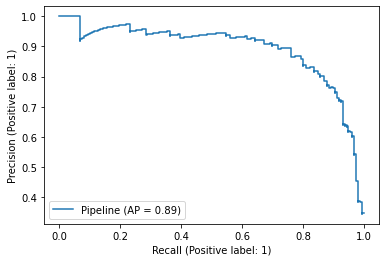

In [160]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])

In [161]:
np.where(prec > 0.95)

(array([398, 412, 413, 414, 415, 416, 417, 418, 421, 422, 423, 424, 425,
        426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
        448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459],
       dtype=int64),)

In [163]:
thresholds[398]

0.7080549871408018

In [164]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[398])

0.95

In [165]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[398])

0.3584905660377358

In [166]:
# То есть при увеличении фильтра до 0.95, модель меньше пропускает нетоксичные комменты

In [167]:
#Пробую подобрать наиболее оптимальные параметры для работы модели
# Сделаю это с помощью кросс-валидации методом .GridSearchCV

In [168]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        )
    )
])

In [169]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.687 total time=   0.3s
[CV 2/3] END .............................C=0.1;, score=0.683 total time=   0.2s
[CV 3/3] END .............................C=0.1;, score=0.687 total time=   0.3s
[CV 1/3] END ...............................C=1;, score=0.839 total time=   0.5s
[CV 2/3] END ...............................C=1;, score=0.832 total time=   0.4s
[CV 3/3] END ...............................C=1;, score=0.843 total time=   0.5s


C:\Users\qwert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ............................C=10.0;, score=0.864 total time=   0.8s


C:\Users\qwert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ............................C=10.0;, score=0.862 total time=   0.8s


C:\Users\qwert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ............................C=10.0;, score=0.871 total time=   0.7s


C:\Users\qwert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x00000260493C8F70>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [170]:
# C=10 параметры наиболее оптимальны. Пробую занаво тренировать модель.

In [171]:
model_pipeline_c10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state = 0, C=10))
])

In [172]:
model_pipeline_c10.fit(train_df["comment"], train_df["toxic"])

C:\Users\qwert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x00000260476DD670>)),
                ('model', LogisticRegression(C=10, random_state=0))])

In [173]:
prec_c10, rec_c10, thresholds_c10 = precision_recall_curve(y_true=test_df["toxic"], \
                                               probas_pred=model_pipeline_c10.predict_proba(test_df["comment"])[:, 1])

C:\Users\qwert\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


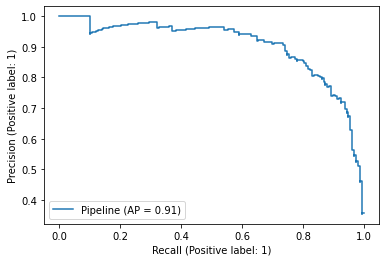

In [174]:
plot_precision_recall_curve(estimator=model_pipeline_c10, X=test_df["comment"], y=test_df["toxic"])

In [175]:
np.where(prec_c10 > 0.95)

(array([351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363,
        364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376,
        377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389,
        390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
        403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
        416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 430, 431, 432,
        433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445,
        446], dtype=int64),)

In [176]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c10.predict_proba(test_df["comment"])[:, 1] > thresholds_c10[351])

0.9574468085106383

In [177]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c10.predict_proba(test_df["comment"])[:, 1] > thresholds_c10[351])

0.5660377358490566

In [106]:
# Таким образом модель будет лучше пропускать нетоксичные комменты (почти х2 раза) 
# и находить негативные комменты при сохранении порогового значения в 0.95